# Keras - CIFAR 10 - CNN Tricks

---

## 目標
* 透過 `CIFAR 10` 資料集, 了解如何在`keras`上建構模型.  
* 了解`CNN model`面對過度最佳化可以使用的基本技巧.  

## 索引
### [1 載入資料](#1.-載入資料)
[1.1 下載資料集](#1.1-下載資料集)  
[1.2 檢查圖片內容](#1.2-檢查圖片內容)  
[1.3 檢查資料平衡](#1.3-檢查資料平衡)
### [2 CNN model tricks](#2.-CNN-model-tricks)
[2.1 Block](#2.1-Block)  
[2.2 DATA Augmentation](#2.2-DATA-Augmentation)  
[2.3 Learning Rate Schedule](#2.3-Learning-Rate-Schedule)  
[2.4 Batch Normalization](#2.4-Batch-Normalization)  
[2.5 Initializer](#2.5-Initializer)  
[2.6 Activation](#2.6-Activation)

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import time, os
import matplotlib.pyplot as plt

In [106]:
import keras
from keras import regularizers, optimizers
from keras.utils import to_categorical, np_utils
from keras.models import Model
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Input, Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.initializers import he_uniform, glorot_uniform

## 1. 載入資料

這次要練習的資料, 就是這個啦~~~  
http://www.cs.toronto.edu/~kriz/cifar.html  
大家可以看一下他提供的說明, 不過我簡單介紹一下, 這是迷你照片的資料集.  
裡面有很多32x32的圖片, 簡單版本是將這些照片分為10類, 困難的版本會分出100類.  


### 1.1 下載資料集

In [2]:
# 定義一下我們要下載的是簡單版的 10 類
url = 'http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'

# 在設定一下我們要下載到哪個目錄
destpath = 'datasets'

In [3]:
def download_datasets(url, destpath):
    '''藉由輸入的網址跟目標目錄, 會去下載檔案並且解壓'''
    from six.moves import urllib
    import sys, tarfile
    
    filename = url.split('/')[-1]
    filepath = os.path.join(destpath, 'cifar10')
    def _progress(count, block_size, total_size):
        now = float(count*block_size)/float(total_size)*100.0
        sys.stdout.write('\r {} {}{} {:.1f} %'.format(filename, '>'*int(now/10), '-'*int(10-now/10), now))
        
    filepath, _ = urllib.request.urlretrieve(url, filepath, reporthook=_progress)
    print()
    state_info = os.stat(filepath)
    print()
    print('Successfully Downloaded.', filename, state_info.st_size, 'bytes.')
    tarfile.open(filepath, 'r:gz').extractall(destpath)

In [4]:
download_datasets(url, destpath)

 cifar-10-python.tar.gz >>>>>>>>>> 100.0 %

Successfully Downloaded. cifar-10-python.tar.gz 170498071 bytes.


看到`Successfully`就覺得好放心啊, 我們接著來看一下怎麼打開.   
按照官方的說法, 裡面的檔案分別如下:  
- readme.html     這就是上面放的網址啦
- batches.meta    放著我們的分類標籤所對應的名字
- data_barch_1~5  訓練資料分了五份檔案
- test_batch      測試資料有一個檔案  

接著我們從官網複製一下讀檔案的程式碼.  

In [5]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

偷看一下, 原來裡面存放的是 `pickle`檔案.  
還了解到解開之後會拿到字典, 我們先打開`data_batch_1`來檢查一下.  

In [6]:
bat1 = unpickle('datasets/cifar-10-batches-py/data_batch_1')
print(bat1.keys())

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])


我們檢查了字典的`key`, 分別的意義是:
* b'batch_label' 這是第幾個批次的訓練資料
* b'labels'      照片的類別
* b'data'        照片的內容
* b'filenames'   照片的檔案名字  

現在我們先來檢查一下圖片有沒有問題吧~

### 1.2 檢查圖片內容

In [7]:
bat1[b'data'][4].shape

(3072,)

這時候碰到了一個 `(3072,)` 的鬼東西...  
好險官方有說到圖片是 32 x 32, 加上了 rgb 三個通道後就是 3072 了.  
馬上把他重排一下.  

In [8]:
img = bat1[b'data'][4].reshape((32, 32, 3))

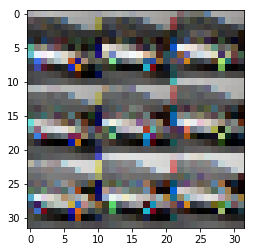

In [9]:
plt.imshow(img)

這下慘了, 一張圖變九張圖...  
帶個參數給他, 用別種方式把圖片排給我們.

In [10]:
img = bat1[b'data'][4].reshape((32, 32, 3), order='F')

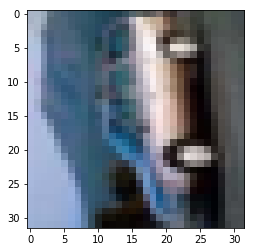

In [11]:
plt.imshow(img)

看來這時候我們拿到了一台車, 但是方向好像錯了...
我們需要自己定義一個方法來旋轉它.

In [12]:
def flip(img, w=32, h=32):
    assert img.shape[0]==img.shape[1]
    
    copy = np.zeros((w,h,3), dtype=np.uint8)
    for i in range(w):
        for j in range(h):
            copy[j, i] = img[i, j]
    return copy    

In [13]:
img_flip = flip(img)

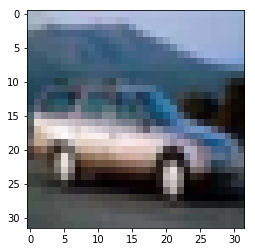

In [14]:
plt.imshow(img_flip)

總算拿到圖了, 這時候我們終於可以確認資料本身沒問題...  
再來檢查一下資料是否平衡吧.

### 1.3 檢查資料平衡

In [15]:
train_batch_list =  ['data_batch_1', 'data_batch_2', 'data_batch_3', 'data_batch_4', 'data_batch_5']

In [16]:
batchs = [unpickle(os.path.join('datasets/cifar-10-batches-py/', train_batch)) for train_batch in train_batch_list]

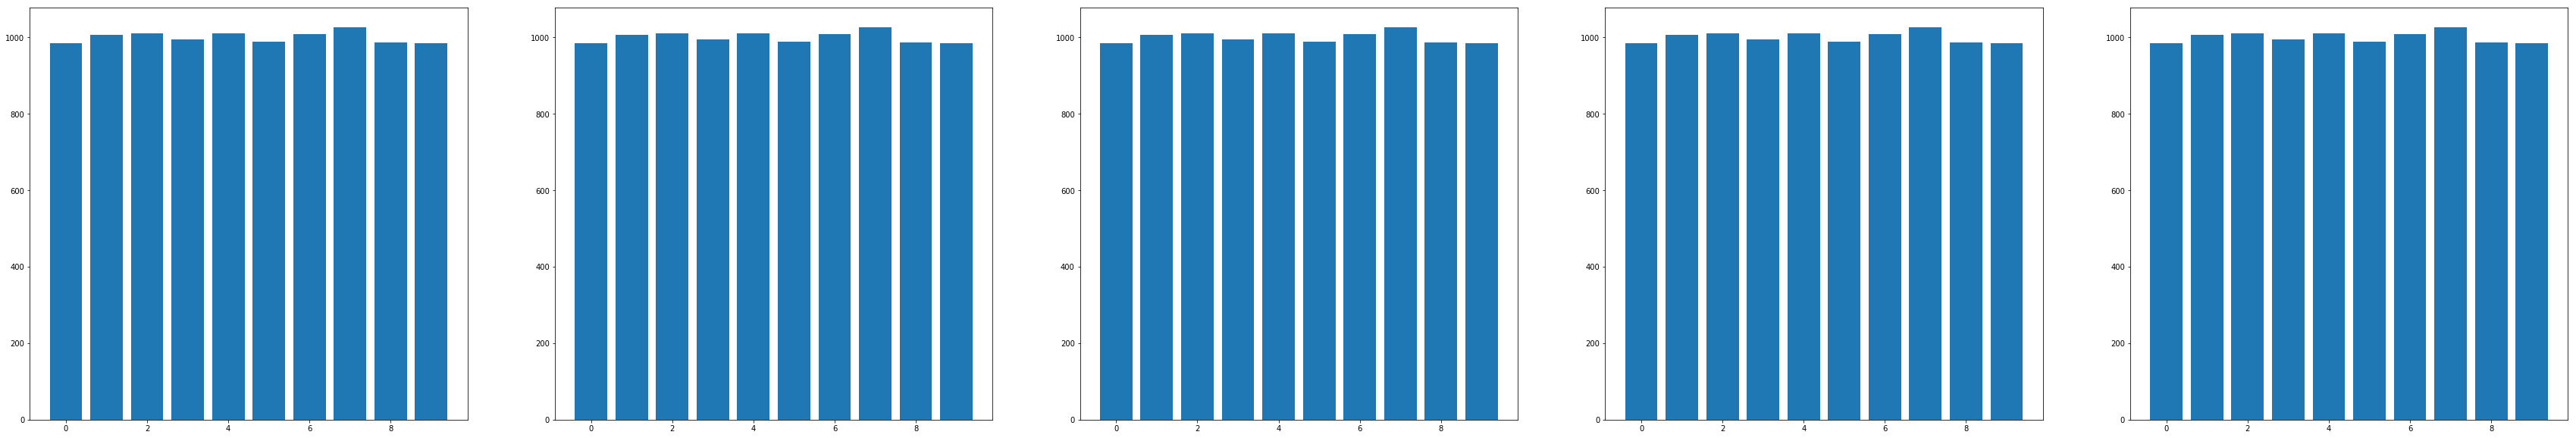

In [17]:
fg, axes = plt.subplots(1,5)
fg.set_size_inches(60, 10)

for idx, bat in enumerate(batchs):
    labels=np.zeros((10))
    for i in range(10):
        labels[i] = (np.array(batchs[1][b'labels'])==i).sum()
    axes[idx].bar(range(len(labels)), labels)
plt.show()

看起來每個資料集都很平均呢.  
接下來正式開始我們的模型設計跟訓練吧

### 1.4 讀取資料

我們資料都檢查完之後, 現在正式把資料讀進來吧~  

In [18]:
train_list =  ['data_batch_1', 'data_batch_2', 'data_batch_3', 'data_batch_4', 'data_batch_5']
test = 'test_batch'

In [19]:
train_data = [unpickle(os.path.join('datasets/cifar-10-batches-py/', train)) for train in train_list]
test_data = unpickle(os.path.join('datasets/cifar-10-batches-py/', test))

In [20]:
x_train=[]
y_train=[]
for train in train_data:
    imgs = train[b'data'].reshape((10000, 32, 32, 3), order='F')
    imgs = [flip(img) for img in imgs]
    x_train.append(imgs)
    y_train.append(train[b'labels'])

x_train = np.array(x_train).reshape((50000, 32, 32, 3))
y_train = np.array(y_train).reshape((50000))

In [21]:
x_test = np.array([flip(test) for test in test_data[b'data'].reshape((10000, 32, 32, 3), order='F')])
y_test = np.array(test_data[b'labels'])

In [22]:
def rand_split(x, y, rate):
    idx = np.array(range(len(y)))
    np.random.shuffle(idx)
    
    x_1 = x[ idx[:int(rate*len(idx)):] ]
    x_2 = x[ idx[int(rate*len(idx))::] ]
    y_1 = y[ idx[:int(rate*len(idx)):] ]
    y_2 = y[ idx[int(rate*len(idx))::] ]
    return x_1, x_2, y_1, y_2

In [23]:
x_train, x_val, y_train, y_val = rand_split(x_train, y_train, 0.8)

In [26]:
# 首先我們將資料轉為 float, 這樣我們才可以進行比較複雜的操作
x_train = x_train.astype('float32')
x_val = x_val.astype('float32')
x_test = x_test.astype('float32')

In [27]:
# 圖片檔的數字範圍是 0~255, 我們將它轉換至 0~1 之間
# Z-score
mean = x_train.mean()
std = x_train.std()

x_train = (x_train-mean)/(std+1e-7) # 為了預防除以零, 加上了一個極小的數字
x_val = (x_val-mean)/(std+1e-7)   # 為了預防除以零, 加上了一個極小的數字
x_test = (x_test-mean)/(std+1e-7)   # 為了預防除以零, 加上了一個極小的數字

In [28]:
# 藉助 keras 的工具直接完成 one hot 格式
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

In [24]:
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(40000, 32, 32, 3) (40000,)
(10000, 32, 32, 3) (10000,)
(10000, 32, 32, 3) (10000,)


現在我們把資料都載進來了, 開始建立模型準備訓練囉~

## 2. CNN model tricks

這邊主要展示一些建構CNN使用的小技巧, 使用大家(我自己)熟練的`keras`套件直接建模.  
使用`keras`會讓程式碼精簡很多, 也就是我可以專心在建模上面, 大家也可以比較清楚的看到模型內容.  

### 2.1 Block

首先我們定義一個方法來快速建立一個模型, 大部分內容都是固定的.  
這邊可以特別注意一下, 我們使用`keras.model.Model`的API, 而不是`keras.model.Sequential`.  
這個API可以比較好的支援我們定義自己的block, 可以看到使用了block的程式碼是非常簡潔的.  
馬上就來跑一次看看吧.  

In [113]:
def make_a_model(use_bn=False, summary=False, init='Xavier', activation='relu'):
    '''這種方式建立模型, 可以大幅精簡程式碼, 由於我們需要不斷增加新的內容或者修改內容, 因此使用這個API快速建立新的網路.'''
    
    # 設定模型的參數, 最終分10類, 神經元數量由32開始增加, 正則化的lambda設定為1e-4
    num_classes = 10
    baseMapNum = 32
    weight_decay = 1e-4
    
    # 目前只設定 he 跟 Xavier 兩種初始化方法, 有需要可以再增加
    if init=='he':
        init = he_uniform()
    elif init=='Xavier':
        init = glorot_uniform()
    
    # 由於 Conv 基本都會搭配 bn + pool, 把這個順序打包成一個 block 可以簡化程式碼, 而且也不會漏掉東西.
    def conv_block(inputs, bias=1, use_bn=False, drop_rate=0.2):
        
        # Conv + bn + Conv + bn + MaxPool + Dropout 綁定成一個 block
        x = Conv2D(bias*baseMapNum, (3,3), padding='same',
                   kernel_regularizer=regularizers.l2(weight_decay),
                   kernel_initializer=init)(inputs)
        x = Activation(activation)(x)
        if use_bn : x = BatchNormalization()(x)
        x = Conv2D(bias*baseMapNum, (3,3), padding='same',
                   kernel_regularizer=regularizers.l2(weight_decay),
                   kernel_initializer=init)(x)
        x = Activation(activation)(x)
        if use_bn : x = BatchNormalization()(x)
        x = MaxPooling2D(pool_size=(2,2))(x)
        x = Dropout(drop_rate)(x)
        
        return x
    
    # 這邊真正開始定義模型, 這是很簡單的 CNN Model 
    # 我們設定了 inputs -> 3 x Conv_Block -> Flatten -> outputs 的簡單結構
    inputs = Input(shape=x_train.shape[1:])
    x = conv_block(inputs, use_bn=use_bn, drop_rate=0.2)
    x = conv_block( x , 2, use_bn=use_bn, drop_rate=0.3)
    x = conv_block( x , 4, use_bn=use_bn, drop_rate=0.4)
    x = Flatten()(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    
    # 如果想看用了多少參數, 或者想看到整個模型, summary 要傳入 True
    if summary: model.summary()
    
    return model

為了進行後面的技巧教學, 我們特地只使用10000筆資料來訓練.  
其實這樣的資料量是不夠的, 等等我們就可以看到發生了最不願意見到的`overfitting`.  

In [84]:
batch_size = 64
epochs=30

opt_rms = keras.optimizers.rmsprop(lr=0.001,decay=1e-6)
model = make_a_model()
model.compile(loss='categorical_crossentropy',
        optimizer=opt_rms,
        metrics=['accuracy'])
train_record  = model.fit_generator(ImageDataGenerator().flow(x_train[:10000], y_train[:10000], batch_size=batch_size),
                                    steps_per_epoch=x_train.shape[0] // batch_size,
                                    epochs=epochs,
                                    verbose=1,
                                    validation_data=(x_val[:5000], y_val[:5000]))
model.save_weights('cnn.h5')

Epoch 1/30
625/625 [==============================] - 17s 28ms/step - loss: 1.6637 - acc: 0.4057 - val_loss: 1.2976 - val_acc: 0.5468
Epoch 2/30
625/625 [==============================] - 15s 24ms/step - loss: 1.1587 - acc: 0.6044 - val_loss: 1.3454 - val_acc: 0.5532
Epoch 3/30
625/625 [==============================] - 15s 24ms/step - loss: 0.8885 - acc: 0.7075 - val_loss: 1.0225 - val_acc: 0.6718
Epoch 4/30
625/625 [==============================] - 15s 24ms/step - loss: 0.7116 - acc: 0.7737 - val_loss: 0.9410 - val_acc: 0.7074
Epoch 5/30
625/625 [==============================] - 15s 24ms/step - loss: 0.5857 - acc: 0.8222 - val_loss: 1.0955 - val_acc: 0.6920
Epoch 6/30
625/625 [==============================] - 15s 24ms/step - loss: 0.5070 - acc: 0.8554 - val_loss: 1.0710 - val_acc: 0.7158
Epoch 7/30
625/625 [==============================] - 15s 24ms/step - loss: 0.4546 - acc: 0.8750 - val_loss: 1.1852 - val_acc: 0.7076
Epoch 8/30
625/625 [==============================] - 15s 24ms

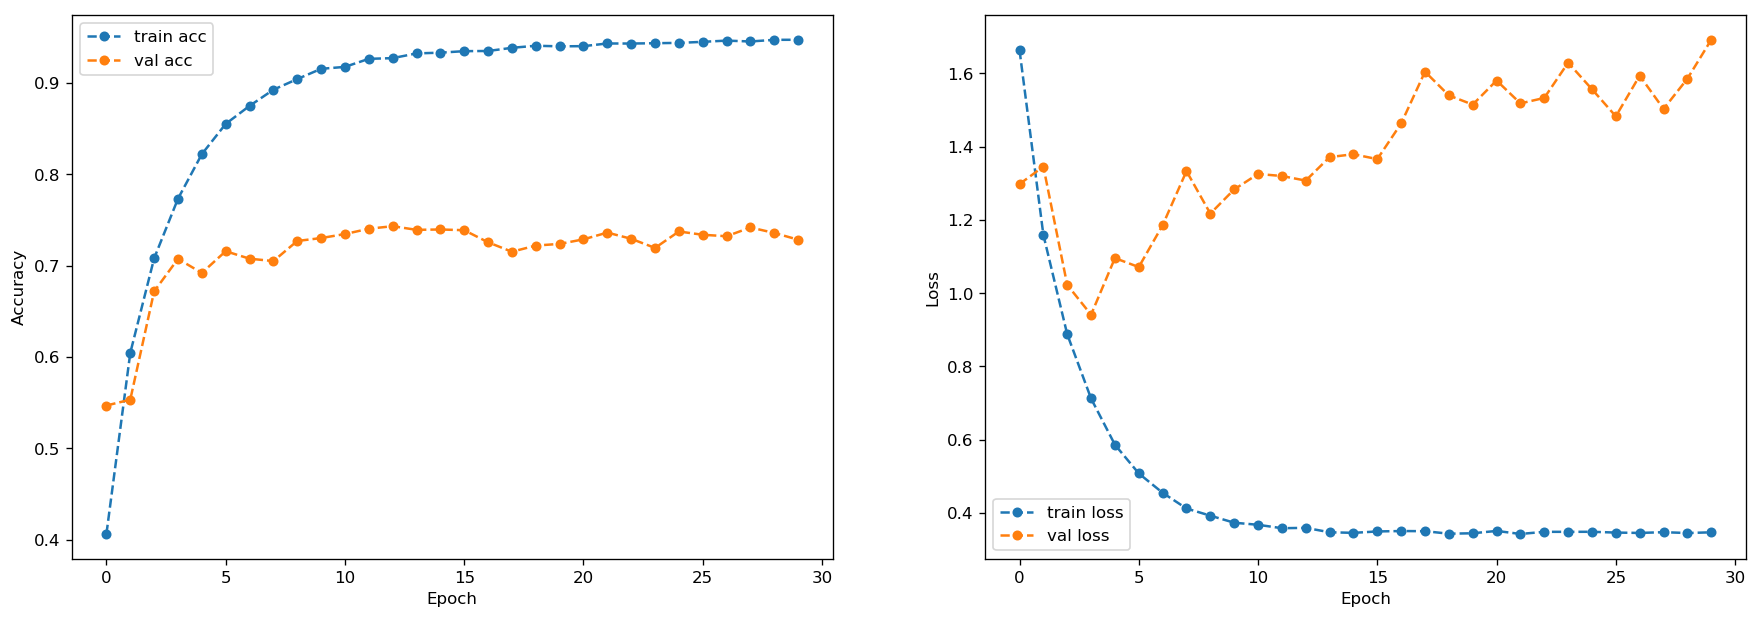

In [85]:
#畫出訓練過程
fig,axes=plt.subplots(1,2,figsize=(18,6),dpi=120)
axes[0].plot(train_record.history['acc'],ms=5,marker='o',label='train acc',ls='--')
axes[0].plot(train_record.history['val_acc'],ms=5,marker='o',label='val acc',ls='--')
axes[0].legend()
axes[1].plot(train_record.history['loss'],ms=5,marker='o',label='train loss',ls='--')
axes[1].plot(train_record.history['val_loss'],ms=5,marker='o',label='val loss',ls='--')
axes[1].legend()

for idx,ax in enumerate(axes):
    ax.set_xlabel('Epoch')
    if idx==0:
        ax.set_ylabel('Accuracy')
    else:
        ax.set_ylabel('Loss')
plt.show()

看到了很明顯的`overfitting`, 因此我們要開始使用各種方法來對付它.  

### 2.2 DATA Augmentation

其實, 深度學習在機器視覺的成功, 有很大成分歸功於我們擁有了很大量標記訓練資料集.  
然而, 收集海量的資料實際上是非常困難的, 因此就出現了`資料增強`這個新的技術來輔助我們提高資料難度以及擴增資料.  
雖然說是資料增強, 但是實際上只適用於圖片, 因此也叫做`圖片增強`.  
當我們資料的數據不夠, 很容易發生`overfitting`, 這時候這個圖片增強就可以派上用場了.  

In [80]:
# 設定了 "旋轉圖片", "水平垂直移動", "圖片傾斜", "水平翻轉"
# 經過了增強的圖片可以說跟本來完全不一樣, 因此這個動作可以大幅增加圖片數量
datagen = ImageDataGenerator(
    featurewise_center=False, # 使全體資料平均值為零
    samplewise_center=False,  # 使個別資料平均值為零
    featurewise_std_normalization=False, # 將全體資料除以標準差
    samplewise_std_normalization=False,  # 將個別資料除以標準差
    zca_whitening=False,  # 對圖片進行降維
    rotation_range=30,  # 對圖片隨機進行小於指定角度的旋轉
    width_shift_range=0.2,   # 將圖片平行移動小於指定比例的距離
    height_shift_range=0.2,  # 將圖片垂直移動小於指定比例的距離
    shear_range=0.2,         # 讓圖片發生傾斜
    zoom_range=0.0,          # 放大或縮小, 0~1之間是放大, 1以上是縮小
    horizontal_flip=True,    # 隨機將圖片水平翻轉
    vertical_flip=False      # 隨機將圖片上下翻轉
    )
datagen.fit(x_train)

In [87]:
batch_size = 64
epochs=30

opt_rms = keras.optimizers.rmsprop(lr=0.001,decay=1e-6)
model = make_a_model()
model.compile(loss='categorical_crossentropy',
        optimizer=opt_rms,
        metrics=['accuracy'])
train_record  = model.fit_generator(datagen.flow(x_train[:10000], y_train[:10000], batch_size=batch_size),
                                    steps_per_epoch=x_train.shape[0] // batch_size,
                                    epochs=epochs,
                                    verbose=1,
                                    validation_data=(x_val[:5000], y_val[:5000]))
model.save_weights('cnn.h5')

Epoch 1/30
625/625 [==============================] - 31s 50ms/step - loss: 1.8335 - acc: 0.3322 - val_loss: 1.6013 - val_acc: 0.4340
Epoch 2/30
625/625 [==============================] - 29s 47ms/step - loss: 1.5124 - acc: 0.4623 - val_loss: 1.6465 - val_acc: 0.4794
Epoch 3/30
625/625 [==============================] - 29s 46ms/step - loss: 1.3708 - acc: 0.5248 - val_loss: 1.7123 - val_acc: 0.4866
Epoch 4/30
625/625 [==============================] - 28s 46ms/step - loss: 1.2778 - acc: 0.5620 - val_loss: 1.2022 - val_acc: 0.6008
Epoch 5/30
625/625 [==============================] - 29s 47ms/step - loss: 1.2192 - acc: 0.5881 - val_loss: 1.0598 - val_acc: 0.6470
Epoch 6/30
625/625 [==============================] - 29s 46ms/step - loss: 1.1582 - acc: 0.6133 - val_loss: 1.1641 - val_acc: 0.6312
Epoch 7/30
625/625 [==============================] - 27s 43ms/step - loss: 1.1197 - acc: 0.6306 - val_loss: 1.3554 - val_acc: 0.5960
Epoch 8/30
625/625 [==============================] - 27s 44ms

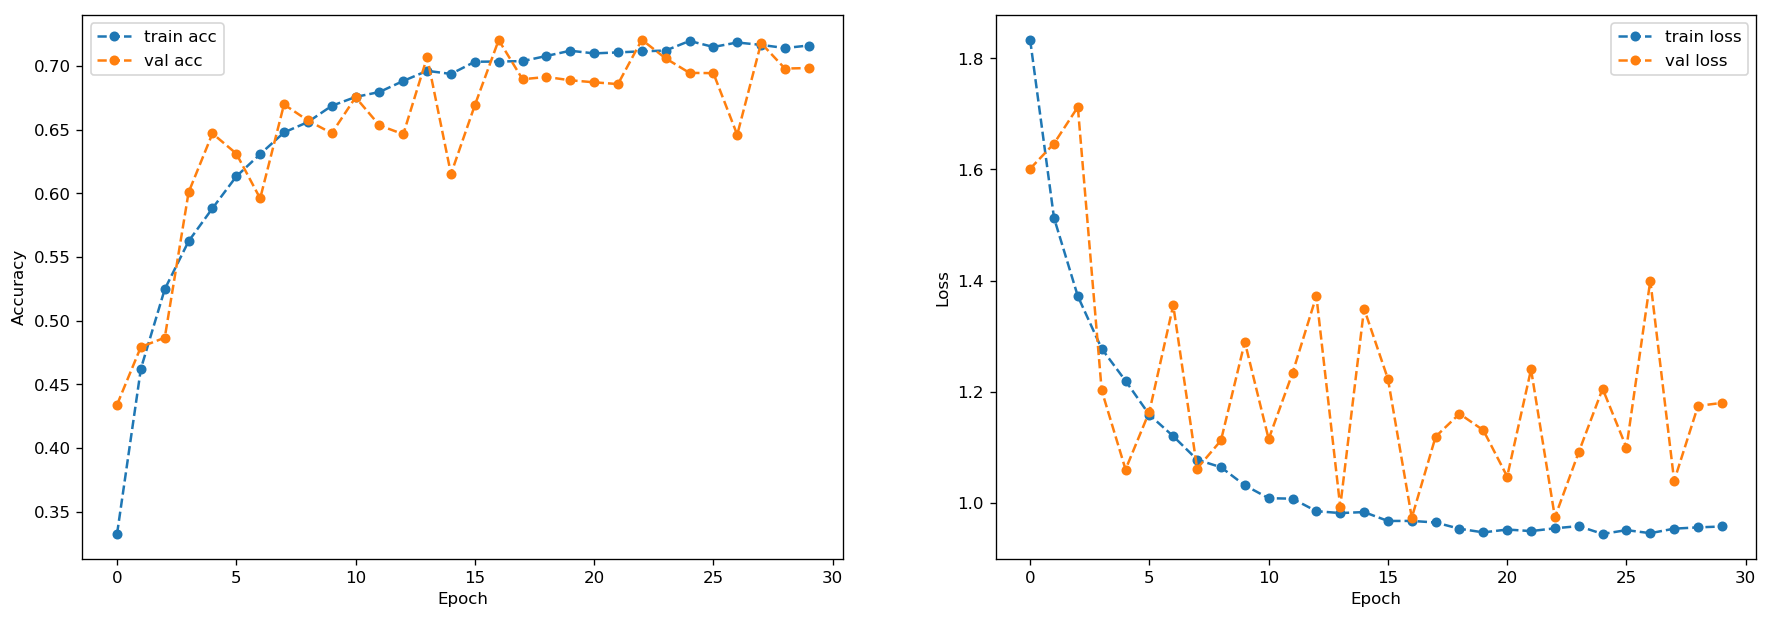

In [88]:
#畫出訓練過程
fig,axes=plt.subplots(1,2,figsize=(18,6),dpi=120)
axes[0].plot(train_record.history['acc'],ms=5,marker='o',label='train acc',ls='--')
axes[0].plot(train_record.history['val_acc'],ms=5,marker='o',label='val acc',ls='--')
axes[0].legend()
axes[1].plot(train_record.history['loss'],ms=5,marker='o',label='train loss',ls='--')
axes[1].plot(train_record.history['val_loss'],ms=5,marker='o',label='val loss',ls='--')
axes[1].legend()

for idx,ax in enumerate(axes):
    ax.set_xlabel('Epoch')
    if idx==0:
        ax.set_ylabel('Accuracy')
    else:
        ax.set_ylabel('Loss')
plt.show()

使用了`dATA augmentation`之後可以看到明顯改善了overfitting.  
但還是不夠.  


### 2.3 Learning Rate Schedule

我們在訓練模型的期間, 由於初始時可能離目標很遠, 我們會希望學習速率大一點.  
隨著訓練進行, 我們會希望速率降低, 能夠更精準的修正參數.  

In [116]:
def lr_schedule(epoch):
    '''定義 learning rate 的方法, 藉由輸入epoch輸出learning rate'''
    
    if epoch <= 50:
        lr = 0.001
    elif epoch <= 75:
        lr = 0.0005
    elif epoch <=100  :
        lr = 0.0003
    else :    
        lr = 0.0001
        
    return lr

In [96]:
class LossHistory(keras.callbacks.Callback):
    '''繼承了keras.callbacks.Callback, 這能夠用來觀察訓練期間的統計資料'''
    
    # 在訓練開始的時候被呼叫
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []
 
    # 在每個 epoch 結束的時候被呼叫
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))            # 儲存 loss 資料, 結束後可以查看
        self.lr.append(lr_schedule(len(self.losses)))   # 儲存 lr 資料, 結束後可以查看

In [99]:
batch_size = 64
epochs=100 # 由於增加 learning sedule, 我們需要更多的 epochs

opt_rms = keras.optimizers.rmsprop(lr=0.001,decay=1e-6)

# 將定義的function傳入Keras.callbacks.LearningRateScheduler, 會在每次 epoch 開始的時候更新 learning rate
lrate = keras.callbacks.LearningRateScheduler(lr_schedule) 

# 儲存 lr 資料, 之後我們使用這個物件來讀取 learning rate 變動的情況
losshis = LossHistory() 

model = make_a_model(use_bn=False)
model.compile(loss='categorical_crossentropy',
        optimizer=opt_rms,
        metrics=['accuracy'])
train_record  = model.fit_generator(datagen.flow(x_train[:10000], y_train[:10000], batch_size=batch_size),
                                    steps_per_epoch=x_train.shape[0] // batch_size,
                                    epochs=epochs,
                                    callbacks=[lrate, losshis],  # 使用 callbacks 紀錄我們需要的資訊
                                    verbose=1,
                                    validation_data=(x_val[:5000], y_val[:5000]))
model.save_weights('cnn.h5')

Epoch 1/100
625/625 [==============================] - 34s 55ms/step - loss: 1.8506 - acc: 0.3242 - val_loss: 1.5754 - val_acc: 0.4446
Epoch 2/100
625/625 [==============================] - 29s 47ms/step - loss: 1.5330 - acc: 0.4568 - val_loss: 1.3115 - val_acc: 0.5472
Epoch 3/100
625/625 [==============================] - 30s 47ms/step - loss: 1.3876 - acc: 0.5148 - val_loss: 1.3338 - val_acc: 0.5696
Epoch 4/100
625/625 [==============================] - 29s 47ms/step - loss: 1.2897 - acc: 0.5592 - val_loss: 1.1998 - val_acc: 0.6148
Epoch 5/100
625/625 [==============================] - 29s 47ms/step - loss: 1.2103 - acc: 0.5885 - val_loss: 1.0317 - val_acc: 0.6690
Epoch 6/100
625/625 [==============================] - 29s 46ms/step - loss: 1.1602 - acc: 0.6114 - val_loss: 1.2009 - val_acc: 0.6242
Epoch 7/100
625/625 [==============================] - 29s 47ms/step - loss: 1.1099 - acc: 0.6303 - val_loss: 1.2461 - val_acc: 0.6126
Epoch 8/100
625/625 [==============================] - 

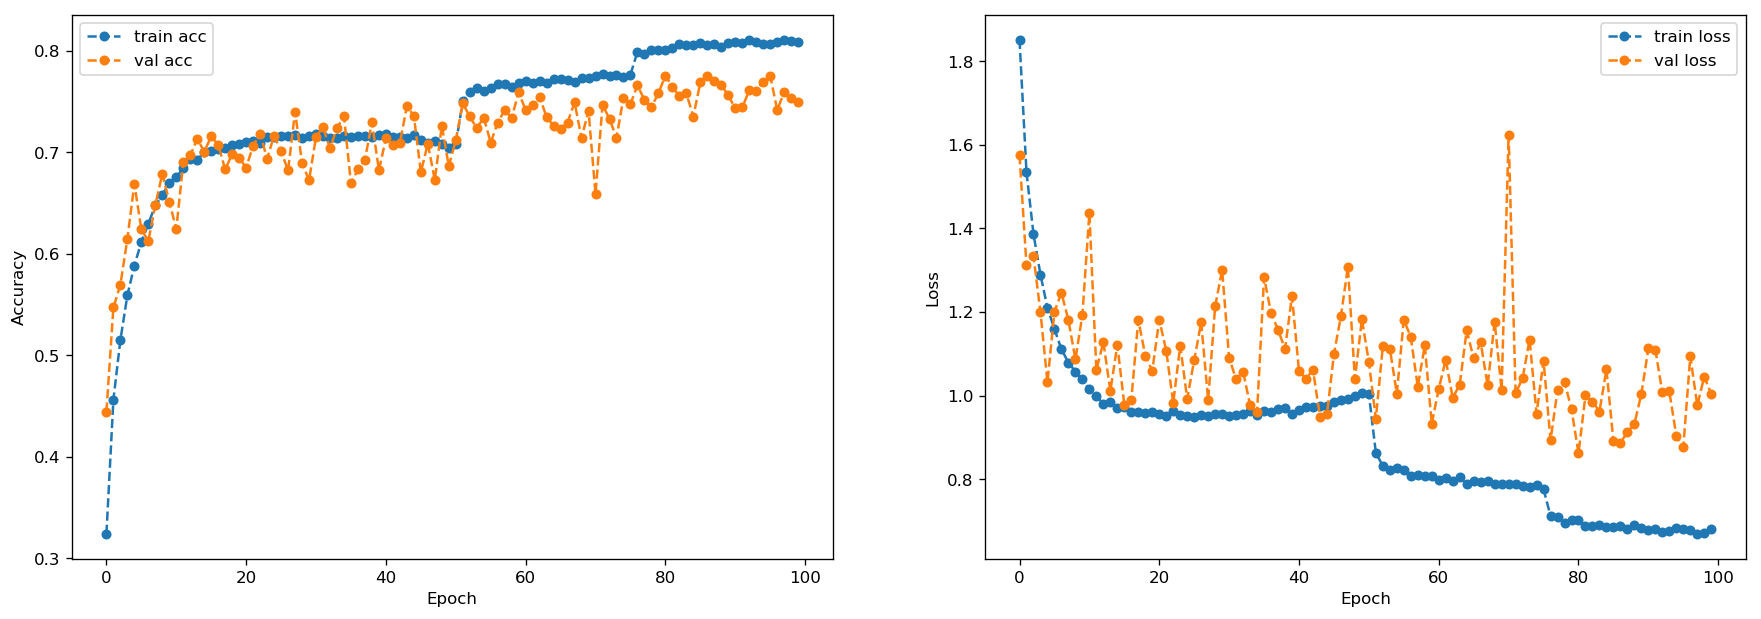

In [100]:
#畫出訓練過程
fig,axes=plt.subplots(1,2,figsize=(18,6),dpi=120)
axes[0].plot(train_record.history['acc'],ms=5,marker='o',label='train acc',ls='--')
axes[0].plot(train_record.history['val_acc'],ms=5,marker='o',label='val acc',ls='--')
axes[0].legend()
axes[1].plot(train_record.history['loss'],ms=5,marker='o',label='train loss',ls='--')
axes[1].plot(train_record.history['val_loss'],ms=5,marker='o',label='val loss',ls='--')
axes[1].legend()

for idx,ax in enumerate(axes):
    ax.set_xlabel('Epoch')
    if idx==0:
        ax.set_ylabel('Accuracy')
    else:
        ax.set_ylabel('Loss')
plt.show()

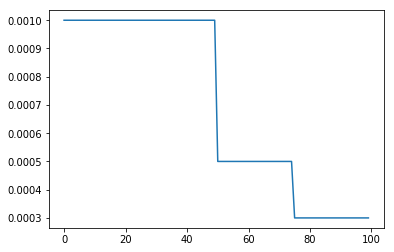

In [101]:
plt.plot(losshis.lr)

在每次更新 learning rate 後, 模型的迭代情況都獲得了改善,  
這證明了適當的設定 learning rate schedule 可以讓我們模型學習得更好.  
但是由於超參數並不能夠透過訓練更新, 因此這還是很依靠人工來進行設定.  
但是其實還是可以透過decay隨著訓練自動調整, 實際的使用還是要看當下的情況以及經驗調整.  

### 2.4 Batch Normalization

這邊我們要介紹另一個重要的層, 這是在2015年由Google所使用的稱為`批量正規化 batch normalization`的技術.  
我們可以把一個正向饋送的神經網路想像成在堆積木,  
如果積木堆的很整齊, 結構就會很穩定.  
但是如果積木疊的很亂, 最後就會整個垮掉.  

在神經網路中也有類似的現象, 當底層的輸出分布開始出現偏移的情況時, 頂層不僅要學會如何正確的預測, 還需要修正來自前面的誤差.  
這樣一來會大大減緩訓練的速度, 而且當網路的層數越多, 這個問題也會更加嚴重.  
因此在各層輸出的前後進行正規化是個非常誘人的作法, 

In [102]:
# 我們在每次 conv 之後都加入了 batch normalization, 其他全都跟剛才一樣
batch_size = 64
epochs=100

opt_rms = keras.optimizers.rmsprop(lr=0.001,decay=1e-6)
lrate = keras.callbacks.LearningRateScheduler(lr_schedule)
losshis = LossHistory()

model = make_a_model(use_bn=True) 
model.compile(loss='categorical_crossentropy',
        optimizer=opt_rms,
        metrics=['accuracy'])
train_record  = model.fit_generator(datagen.flow(x_train[:10000], y_train[:10000], batch_size=batch_size),
                                    steps_per_epoch=x_train.shape[0] // batch_size,
                                    epochs=epochs,
                                    callbacks=[lrate, losshis],
                                    verbose=1,
                                    validation_data=(x_val[:5000], y_val[:5000]))
model.save_weights('cnn.h5')

Epoch 1/100
625/625 [==============================] - 34s 55ms/step - loss: 2.1654 - acc: 0.3594 - val_loss: 2.2225 - val_acc: 0.4098
Epoch 2/100
625/625 [==============================] - 29s 46ms/step - loss: 1.6490 - acc: 0.4835 - val_loss: 1.7161 - val_acc: 0.5072s: 1.6536 - acc: 0 - ETA: 1s - loss: 1.6534 
Epoch 3/100
625/625 [==============================] - 29s 46ms/step - loss: 1.6150 - acc: 0.5287 - val_loss: 1.6026 - val_acc: 0.5402
Epoch 4/100
625/625 [==============================] - 27s 43ms/step - loss: 1.5343 - acc: 0.5522 - val_loss: 1.6994 - val_acc: 0.5608
Epoch 5/100
625/625 [==============================] - 29s 46ms/step - loss: 1.4674 - acc: 0.5835 - val_loss: 1.4957 - val_acc: 0.5690
Epoch 6/100
625/625 [==============================] - 28s 45ms/step - loss: 1.4625 - acc: 0.5927 - val_loss: 1.3182 - val_acc: 0.5832
Epoch 7/100
625/625 [==============================] - 29s 46ms/step - loss: 1.4134 - acc: 0.6100 - val_loss: 1.2581 - val_acc: 0.6222
Epoch 8/100

Epoch 61/100
625/625 [==============================] - 28s 45ms/step - loss: 0.5947 - acc: 0.8485 - val_loss: 0.8925 - val_acc: 0.7888
Epoch 62/100
625/625 [==============================] - 26s 42ms/step - loss: 0.5952 - acc: 0.8480 - val_loss: 0.9687 - val_acc: 0.7816
Epoch 63/100
625/625 [==============================] - 28s 46ms/step - loss: 0.5855 - acc: 0.8497 - val_loss: 0.9381 - val_acc: 0.7880
Epoch 64/100
625/625 [==============================] - 27s 44ms/step - loss: 0.5832 - acc: 0.8512 - val_loss: 0.9615 - val_acc: 0.7764
Epoch 65/100
625/625 [==============================] - 27s 44ms/step - loss: 0.5879 - acc: 0.8495 - val_loss: 0.9356 - val_acc: 0.7914
Epoch 66/100
625/625 [==============================] - 28s 45ms/step - loss: 0.5882 - acc: 0.8500 - val_loss: 0.9455 - val_acc: 0.7864
Epoch 67/100
625/625 [==============================] - 27s 43ms/step - loss: 0.5751 - acc: 0.8531 - val_loss: 1.0632 - val_acc: 0.7706
Epoch 68/100
625/625 [==========================

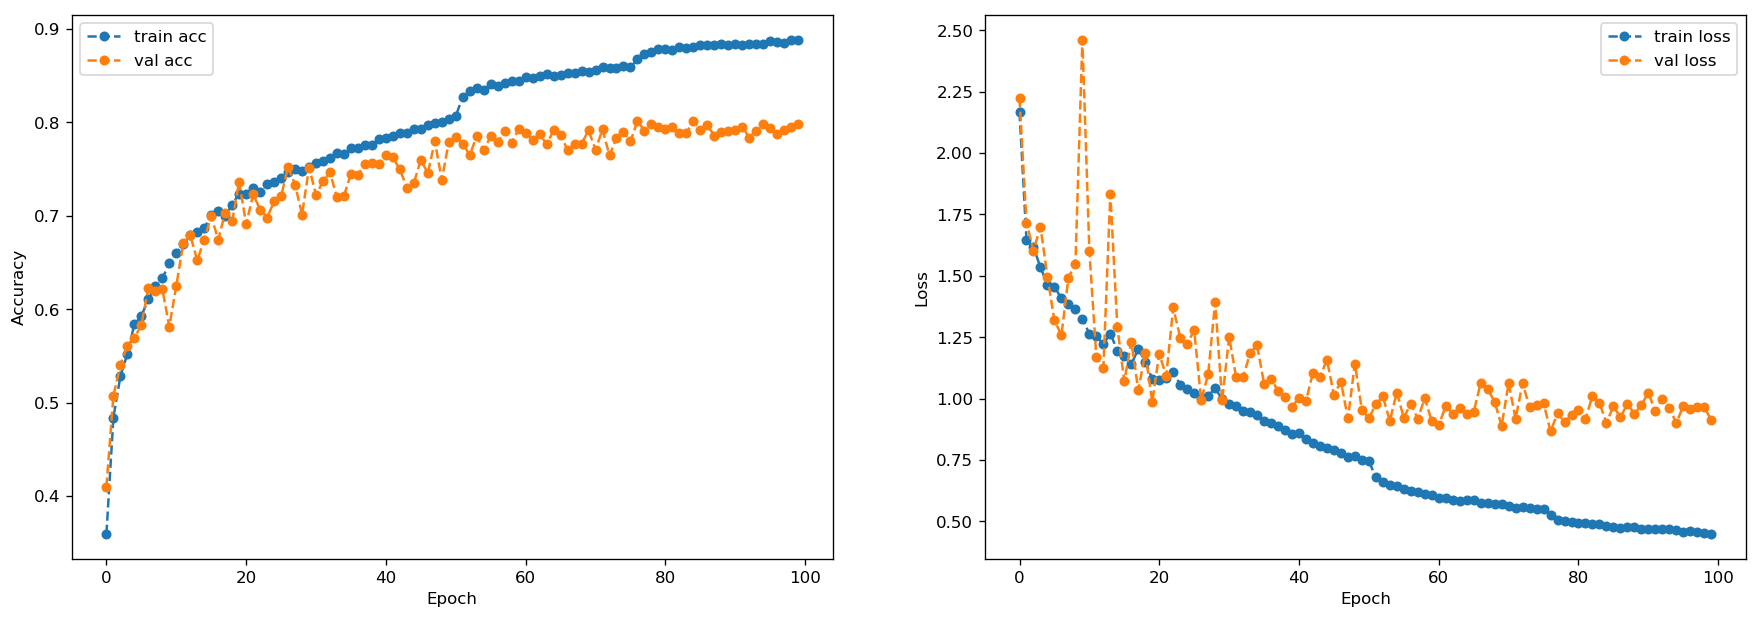

In [103]:
#畫出訓練過程
fig,axes=plt.subplots(1,2,figsize=(18,6),dpi=120)
axes[0].plot(train_record.history['acc'],ms=5,marker='o',label='train acc',ls='--')
axes[0].plot(train_record.history['val_acc'],ms=5,marker='o',label='val acc',ls='--')
axes[0].legend()
axes[1].plot(train_record.history['loss'],ms=5,marker='o',label='train loss',ls='--')
axes[1].plot(train_record.history['val_loss'],ms=5,marker='o',label='val loss',ls='--')
axes[1].legend()

for idx,ax in enumerate(axes):
    ax.set_xlabel('Epoch')
    if idx==0:
        ax.set_ylabel('Accuracy')
    else:
        ax.set_ylabel('Loss')
plt.show()

我們可以看到加入了`batch normalization(bn)`之後整個迭代的過程變得很穩定.  
本來 `val acc` 常常忽上忽下, 修正後這種情況就改善了很多.  
仔細觀察還可以發現本來的模型會在接近 epoch 50 時開始變差.  
但是加入了 `bn` 後這種現象就消失了, 這也是因為學習的效率變得更有效了.

### 2.5 Initializer

除了上面這些之外, 我們還可以改動模型建立的時候的初始化權重方法.  
在深度學習一開始, 大家都是使用的`隨機初始化`, 這導致我們層的輸出會受到神經元個數影響, 會需要模型龐大才能正確的輸出.  
後來出現了`Xavier`的初始化方法, `Keras`預設就是這個, 但是很可惜它並沒有考慮到輸出時的分布影響.  
因此其實在 `CNN Model` 中, 目前最推崇的是 `he` 初始化方法, 它考量了輸出的分布, 可以讓模型設計很深.  
目前這個模型除了`train loss`有稍微改善外看不太出差異, 這主要是因為模型太淺了.  
由於初始化的改善只差在深層輸出的分布, 因此可能要進到更複雜的模型才能顯現出更大的差異來. 

In [111]:
batch_size = 64
epochs=100

opt_rms = keras.optimizers.rmsprop(lr=0.001,decay=1e-6)
lrate = keras.callbacks.LearningRateScheduler(lr_schedule)
losshis = LossHistory()

model = make_a_model(use_bn=True, init='he')
model.compile(loss='categorical_crossentropy',
        optimizer=opt_rms,
        metrics=['accuracy'])
train_record  = model.fit_generator(datagen.flow(x_train[:10000], y_train[:10000], batch_size=batch_size),
                                    steps_per_epoch=x_train.shape[0] // batch_size,
                                    epochs=epochs,
                                    callbacks=[lrate, losshis],
                                    verbose=1,
                                    validation_data=(x_val[:5000], y_val[:5000]))
model.save_weights('cnn.h5')

Epoch 1/100
625/625 [==============================] - 36s 57ms/step - loss: 2.2781 - acc: 0.3441 - val_loss: 1.7625 - val_acc: 0.4396
Epoch 2/100
625/625 [==============================] - 29s 47ms/step - loss: 1.7687 - acc: 0.4688 - val_loss: 2.3217 - val_acc: 0.4776
Epoch 3/100
625/625 [==============================] - 30s 47ms/step - loss: 1.5877 - acc: 0.5282 - val_loss: 1.6152 - val_acc: 0.5384
Epoch 4/100
625/625 [==============================] - 29s 47ms/step - loss: 1.5091 - acc: 0.5657 - val_loss: 1.4512 - val_acc: 0.5984
Epoch 5/100
625/625 [==============================] - 30s 48ms/step - loss: 1.4174 - acc: 0.5962 - val_loss: 1.2948 - val_acc: 0.6302
Epoch 6/100
625/625 [==============================] - 30s 48ms/step - loss: 1.3683 - acc: 0.6195 - val_loss: 1.8015 - val_acc: 0.5930
Epoch 7/100
625/625 [==============================] - 29s 47ms/step - loss: 1.3912 - acc: 0.6265 - val_loss: 1.2141 - val_acc: 0.6398
Epoch 8/100
625/625 [==============================] - 

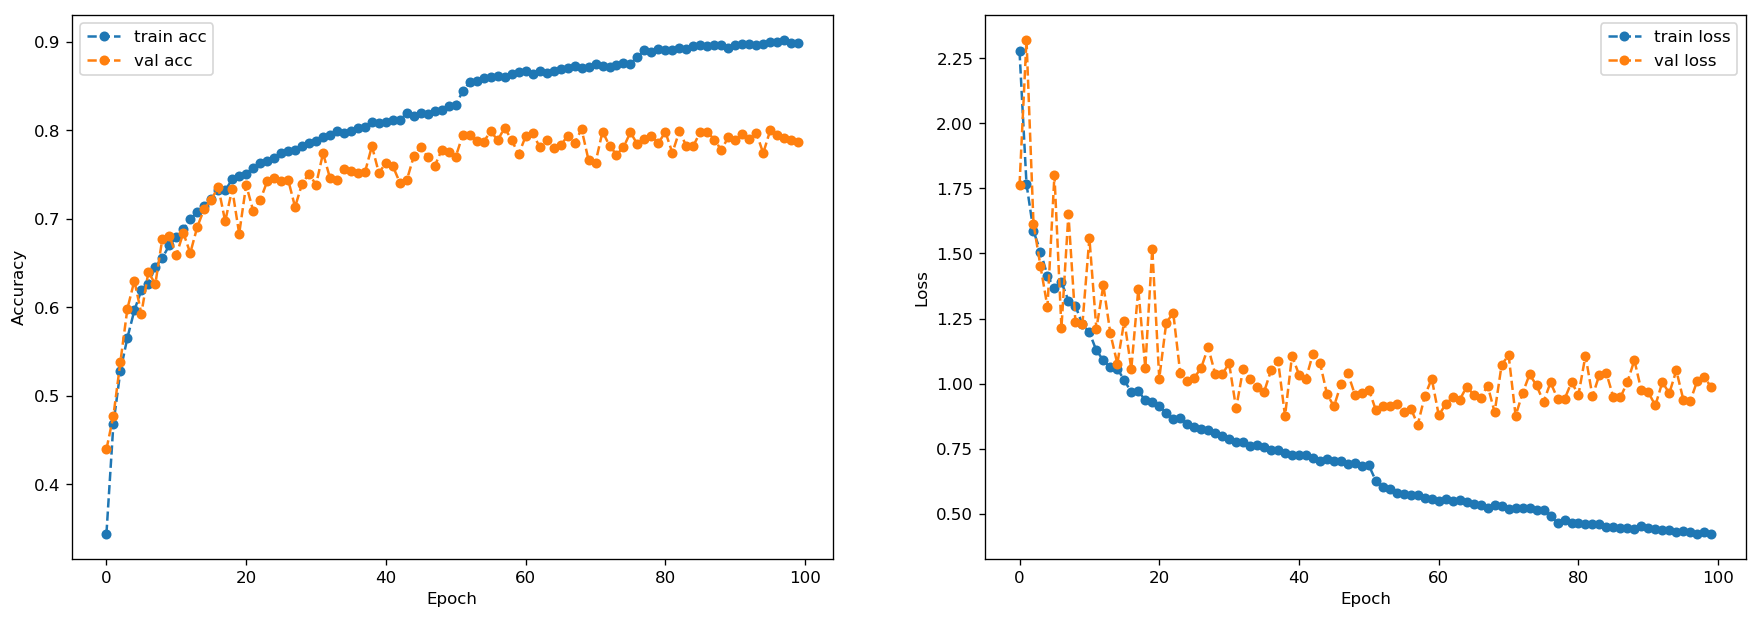

In [112]:
#畫出訓練過程
fig,axes=plt.subplots(1,2,figsize=(18,6),dpi=120)
axes[0].plot(train_record.history['acc'],ms=5,marker='o',label='train acc',ls='--')
axes[0].plot(train_record.history['val_acc'],ms=5,marker='o',label='val acc',ls='--')
axes[0].legend()
axes[1].plot(train_record.history['loss'],ms=5,marker='o',label='train loss',ls='--')
axes[1].plot(train_record.history['val_loss'],ms=5,marker='o',label='val loss',ls='--')
axes[1].legend()

for idx,ax in enumerate(axes):
    ax.set_xlabel('Epoch')
    if idx==0:
        ax.set_ylabel('Accuracy')
    else:
        ax.set_ylabel('Loss')
plt.show()

### 2.6 Activation

<img style="float:left" src="https://i0.wp.com/laid.delanover.com/wp-content/uploads/2017/08/elu.png?resize=300%2C147">
我們知道在深度學習中每一層我們都需要`激活函數 Activation`來進行輸入到輸出的非線性轉換.  
因此這個`Activation`怎麼運作其實是非常非常重要的, 圖中是`relu`以及它相關的函數.  
我們一開始使用`relu`除了有運算簡單(正向, 反向傳遞都簡單)以外, 它在`CNN Model`中也有著非常好的效果, 在機器視覺上`relu 系列`函數幾乎是首選函數而且沒有之一.  

然而, `relu`其實是非常脆弱的神經元, 當輸入為零以下時, 該神經元會壞死.  
一個深度網路, 其實動輒幾十幾百萬的參數, 但是一個沒控制好, 可能模型中有一半以上的`relu`神經元都死光了.  
為了解決這個問題, 於是出現了各種`relu`的改版, 這邊我們換使用 `elu`試試.  
但是還是要注意, 這些改版的函數, 幾乎都犧牲了它們的運算方便性, **電腦規格不夠還是不要輕易嘗試**.

In [114]:
batch_size = 64
epochs=100

opt_rms = keras.optimizers.rmsprop(lr=0.001,decay=1e-6)
lrate = keras.callbacks.LearningRateScheduler(lr_schedule)
losshis = LossHistory()

model = make_a_model(use_bn=True, init='he', activation=vation='elu')
model.compile(loss='categorical_crossentropy',
        optimizer=opt_rms,
        metrics=['accuracy'])
train_record  = model.fit_generator(datagen.flow(x_train[:10000], y_train[:10000], batch_size=batch_size),
                                    steps_per_epoch=x_train.shape[0] // batch_size,
                                    epochs=epochs,
                                    callbacks=[lrate, losshis],
                                    verbose=1,
                                    validation_data=(x_val[:5000], y_val[:5000]))
model.save_weights('cnn.h5')

Epoch 1/100
625/625 [==============================] - 36s 58ms/step - loss: 2.2236 - acc: 0.3575 - val_loss: 2.1165 - val_acc: 0.3834
Epoch 2/100
625/625 [==============================] - 30s 48ms/step - loss: 1.6758 - acc: 0.4950 - val_loss: 1.7702 - val_acc: 0.5104
Epoch 3/100
625/625 [==============================] - 28s 45ms/step - loss: 1.5214 - acc: 0.5489 - val_loss: 1.3643 - val_acc: 0.5866
Epoch 4/100
625/625 [==============================] - 29s 47ms/step - loss: 1.4131 - acc: 0.5850 - val_loss: 1.5609 - val_acc: 0.5496
Epoch 5/100
625/625 [==============================] - 29s 47ms/step - loss: 1.3324 - acc: 0.6140 - val_loss: 1.2628 - val_acc: 0.6280
Epoch 6/100
625/625 [==============================] - 29s 47ms/step - loss: 1.2807 - acc: 0.6387 - val_loss: 1.1865 - val_acc: 0.6704
Epoch 7/100
625/625 [==============================] - 29s 47ms/step - loss: 1.2429 - acc: 0.6546 - val_loss: 1.2621 - val_acc: 0.6474
Epoch 8/100
625/625 [==============================] - 

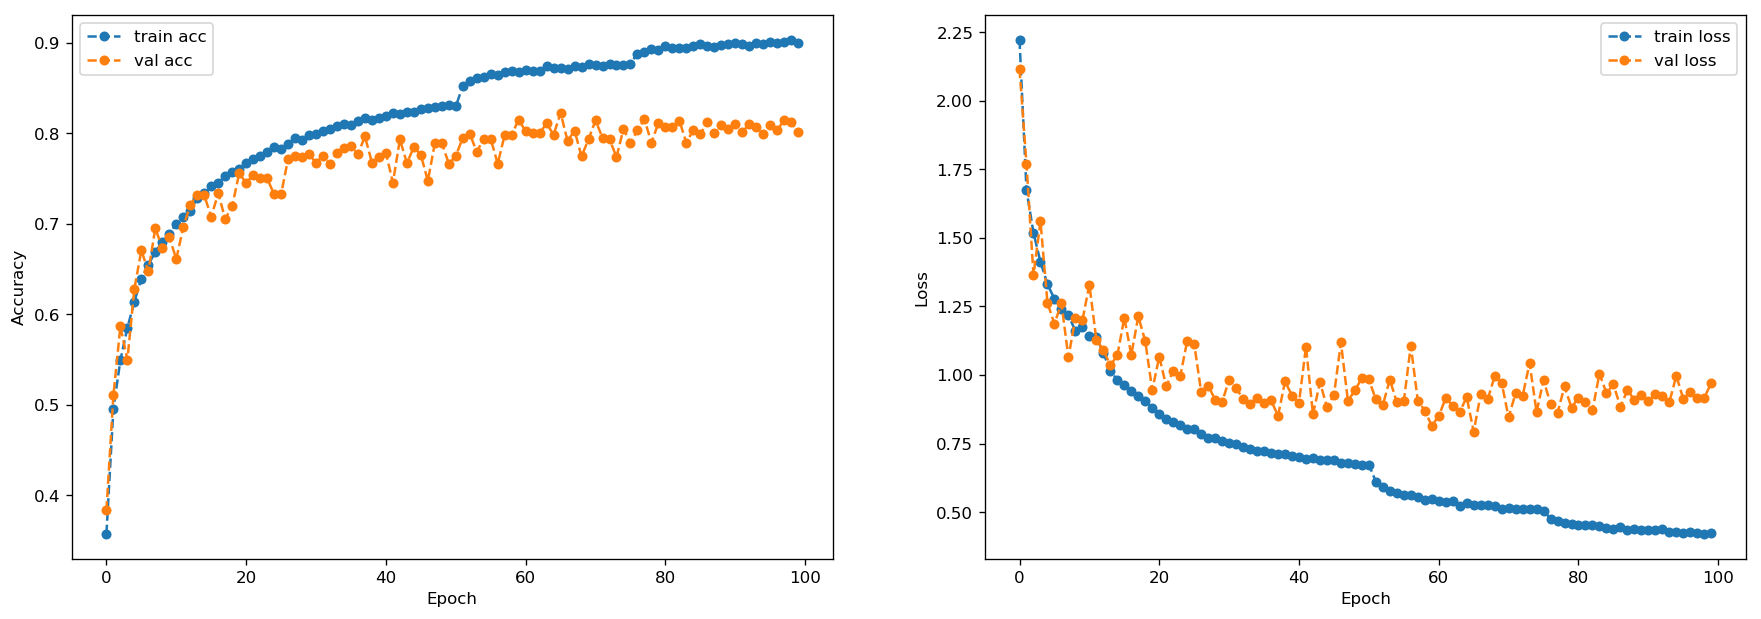

In [115]:
#畫出訓練過程
fig,axes=plt.subplots(1,2,figsize=(18,6),dpi=120)
axes[0].plot(train_record.history['acc'],ms=5,marker='o',label='train acc',ls='--')
axes[0].plot(train_record.history['val_acc'],ms=5,marker='o',label='val acc',ls='--')
axes[0].legend()
axes[1].plot(train_record.history['loss'],ms=5,marker='o',label='train loss',ls='--')
axes[1].plot(train_record.history['val_loss'],ms=5,marker='o',label='val loss',ls='--')
axes[1].legend()

for idx,ax in enumerate(axes):
    ax.set_xlabel('Epoch')
    if idx==0:
        ax.set_ylabel('Accuracy')
    else:
        ax.set_ylabel('Loss')
plt.show()

到這邊我們已經將基礎的 `CNN Tricks`介紹完.  
如果還是沒辦法正確進行分類, 可能就得從模型架構上面下手.  
例如我們可以仿照 `VGG` 設計出自己的 `like-VGG Model` 來進行分析.  
又或者仿照 `ResNet`, `DenseNet` 等模型架構, 都是可以嘗試的方向.  

現在我們把全部的資料丟進去跑看看我們最終模型可以預測到多少吧~

In [123]:
batch_size = 64
epochs=150

opt_rms = keras.optimizers.rmsprop(lr=0.001,decay=1e-6)
lrate = keras.callbacks.LearningRateScheduler(lr_schedule)
losshis = LossHistory()

model = make_a_model(use_bn=True, init='he', activation='elu')
model.compile(loss='categorical_crossentropy',
        optimizer=opt_rms,
        metrics=['accuracy'])
train_record  = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                                    steps_per_epoch=x_train.shape[0] // batch_size,
                                    epochs=epochs,
                                    callbacks=[lrate, losshis],
                                    verbose=1,
                                    validation_data=(x_val, y_val))
model.save_weights('cnn.h5')

Epoch 1/150
625/625 [==============================] - 37s 59ms/step - loss: 2.2516 - acc: 0.3428 - val_loss: 2.0705 - val_acc: 0.4130
Epoch 2/150
625/625 [==============================] - 27s 44ms/step - loss: 1.7827 - acc: 0.4637 - val_loss: 1.4233 - val_acc: 0.5316
Epoch 3/150
625/625 [==============================] - 29s 46ms/step - loss: 1.6468 - acc: 0.5124 - val_loss: 1.3965 - val_acc: 0.5822
Epoch 4/150
625/625 [==============================] - 29s 47ms/step - loss: 1.5555 - acc: 0.5499 - val_loss: 1.3763 - val_acc: 0.5764
Epoch 5/150
625/625 [==============================] - 30s 48ms/step - loss: 1.4942 - acc: 0.5756 - val_loss: 1.3771 - val_acc: 0.6082
Epoch 6/150
625/625 [==============================] - 30s 48ms/step - loss: 1.4256 - acc: 0.5983 - val_loss: 1.1742 - val_acc: 0.6487
Epoch 7/150
625/625 [==============================] - 29s 47ms/step - loss: 1.3955 - acc: 0.6112 - val_loss: 1.1644 - val_acc: 0.6619
Epoch 8/150
625/625 [==============================] - 

625/625 [==============================] - 29s 47ms/step - loss: 0.6895 - acc: 0.8087 - val_loss: 0.6575 - val_acc: 0.8374acc: 0.808
Epoch 62/150
625/625 [==============================] - 30s 48ms/step - loss: 0.6836 - acc: 0.8107 - val_loss: 0.6044 - val_acc: 0.8464
Epoch 63/150
625/625 [==============================] - 29s 46ms/step - loss: 0.6815 - acc: 0.8120 - val_loss: 0.6341 - val_acc: 0.8416
Epoch 64/150
625/625 [==============================] - 30s 48ms/step - loss: 0.6777 - acc: 0.8136 - val_loss: 0.5954 - val_acc: 0.8538
Epoch 65/150
625/625 [==============================] - 30s 48ms/step - loss: 0.6734 - acc: 0.8159 - val_loss: 0.6261 - val_acc: 0.8434
Epoch 66/150
625/625 [==============================] - 30s 47ms/step - loss: 0.6738 - acc: 0.8121 - val_loss: 0.6241 - val_acc: 0.8435
Epoch 67/150
625/625 [==============================] - 29s 46ms/step - loss: 0.6705 - acc: 0.8131 - val_loss: 0.6194 - val_acc: 0.8433
Epoch 68/150
625/625 [=============================

Epoch 121/150
625/625 [==============================] - 29s 47ms/step - loss: 0.5309 - acc: 0.8522 - val_loss: 0.5090 - val_acc: 0.8692
Epoch 122/150
625/625 [==============================] - 30s 47ms/step - loss: 0.5302 - acc: 0.8526 - val_loss: 0.5420 - val_acc: 0.8604
Epoch 123/150
625/625 [==============================] - 29s 47ms/step - loss: 0.5321 - acc: 0.8517 - val_loss: 0.5175 - val_acc: 0.8657
Epoch 124/150
625/625 [==============================] - 30s 47ms/step - loss: 0.5320 - acc: 0.8515 - val_loss: 0.5355 - val_acc: 0.8648
Epoch 125/150
625/625 [==============================] - 29s 47ms/step - loss: 0.5245 - acc: 0.8538 - val_loss: 0.5312 - val_acc: 0.8655
Epoch 126/150
625/625 [==============================] - 30s 48ms/step - loss: 0.5317 - acc: 0.8502 - val_loss: 0.5575 - val_acc: 0.8581
Epoch 127/150
625/625 [==============================] - 29s 47ms/step - loss: 0.5304 - acc: 0.8501 - val_loss: 0.5198 - val_acc: 0.8675
Epoch 128/150
625/625 [==================

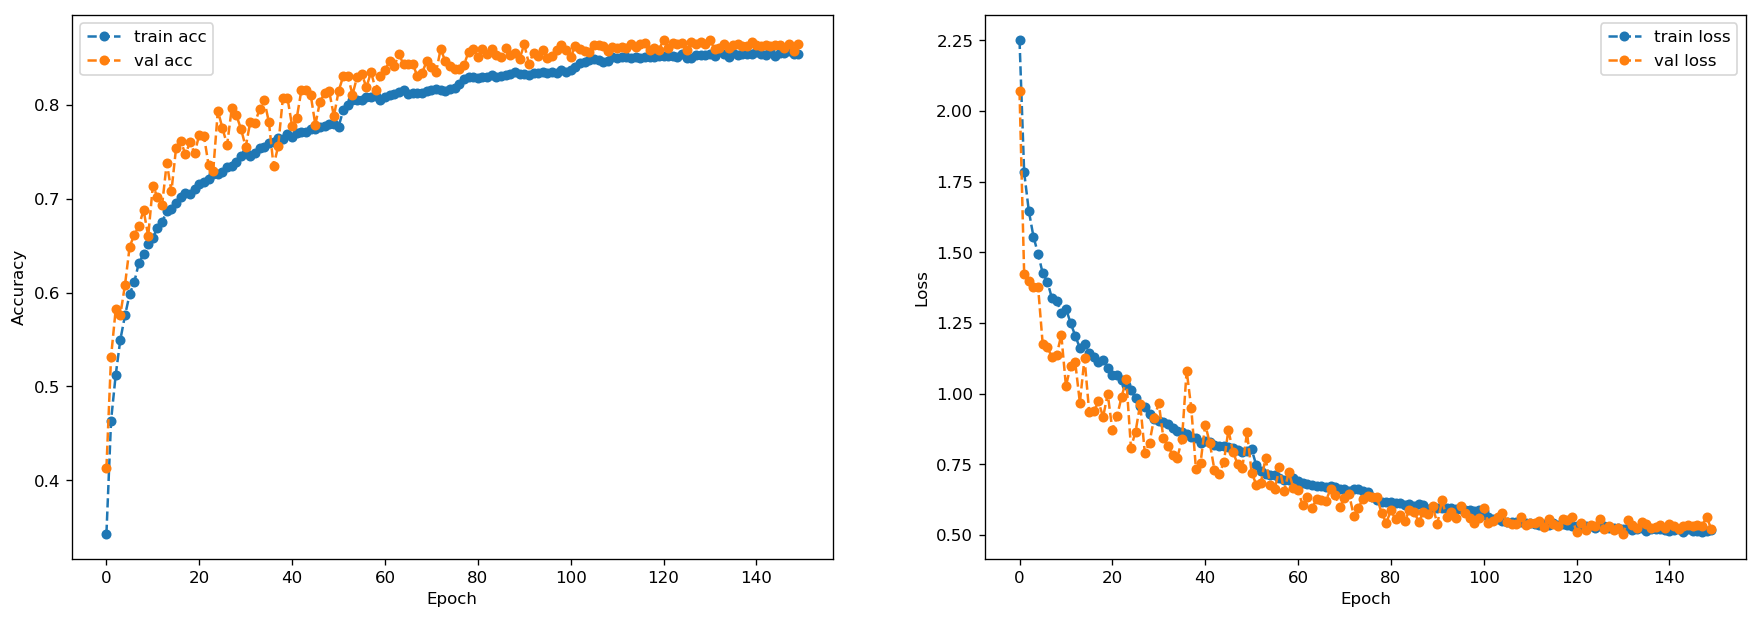

In [124]:
#畫出訓練過程
fig,axes=plt.subplots(1,2,figsize=(18,6),dpi=120)
axes[0].plot(train_record.history['acc'],ms=5,marker='o',label='train acc',ls='--')
axes[0].plot(train_record.history['val_acc'],ms=5,marker='o',label='val acc',ls='--')
axes[0].legend()
axes[1].plot(train_record.history['loss'],ms=5,marker='o',label='train loss',ls='--')
axes[1].plot(train_record.history['val_loss'],ms=5,marker='o',label='val loss',ls='--')
axes[1].legend()

for idx,ax in enumerate(axes):
    ax.set_xlabel('Epoch')
    if idx==0:
        ax.set_ylabel('Accuracy')
    else:
        ax.set_ylabel('Loss')
plt.show()

In [129]:
# 計算模型最終在訓練資料的準確度
(model.predict(x_test).argmax(axis=-1) == y_test.argmax(axis=-1)).sum() / len(y_test)

0.85570000000000002

複習一下我們設計用來對付`overfitting`的技巧：  
* DATA Augmentation
* Learning Rate Schedule
* Batch Normalization
* Initializer
* Activation  

不過其中有許多都還有改進的空間, 當然最後我們或許還需要改進模型的架構.  
但是現在所擁有的這些手段, 已經能夠讓我們在面對 `CIFAR 10` 的資料集獲得85%的準確度了.  